<a href="https://colab.research.google.com/github/talhaanwarch/my_pytorch/blob/master/coivd_tpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import warnings
warnings.filterwarnings(“ignore”)

SyntaxError: ignored

In [32]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [33]:
%%capture
#TPU
!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
#file reading packages
!pip install pydicom
!pip install pylibjpeg
!pip install gdcm
!pip install pylibjpeg-libjpeg
!pip install numpy --upgrade --ignore-installed
#pytorch stuff
!pip install pytorch-lightning
!pip install torchmetrics


In [34]:
import numpy as np
assert np.__version__>='1.20.3', 'Numpy version should be 1.20.3'

In [35]:
import os
if (os.path.isfile('COVIDCTMD.zip')) or (os.path.isdir('data')) is False:
  !wget https://s3-eu-west-1.amazonaws.com/pstorage-npg-968563215/26069987/COVIDCTMD.zip

In [36]:
%%capture
if os.path.isdir('data') is False:
  !mkdir data
  !unzip /content/COVIDCTMD.zip -d data
  !rm /content/COVIDCTMD.zip

In [37]:
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import pydicom as dicom
from glob import glob
import cv2

In [38]:
!rm -rf /content/data/__MACOSX

In [39]:
# clinical_features=pd.read_csv('/content/Clinical-data.csv')
# clinical_features.head()

In [40]:
# df=pd.read_csv('/content/Index.csv')
# df.head()

In [41]:
# df=pd.read_csv('/content/Radiogists-seperated-labels.csv')
# df.head()

2721 0
255 0


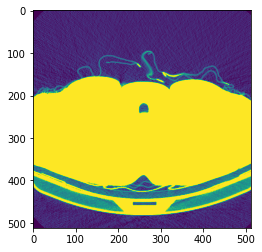

In [42]:
import pydicom as dicom
ds = dicom.dcmread('/content/data/Normal Cases/normal001/IM0001.dcm')
x=np.array(ds.pixel_array)
print(x.max(),x.min())
x = cv2.convertScaleAbs(x)
print(x.max(),x.min())
plt.imshow(x)

In [43]:
'''
This code work for 2D slices of 3D.
It load it into the dataframe
'''

'\nThis code work for 2D slices of 3D.\nIt load it into the dataframe\n'

In [44]:
def flatten(path,label=None):
  '''
  flatten list to single list
  path: images path in a list
  label: corresponding label in list
  '''
  path = [item for sublist in path for item in sublist]
  label = [item for sublist in label for item in sublist]
  return path, label

In [45]:
def prepare_data(path='data',split=True,createDF=True):
  '''
  read data as dataframe 
  path: path of main directory in which classes are present
  split: split data to train and val
  convertDF: create dataframe or return list
  '''
  main_path=glob(path+'/*/')
  image_paths,image_labels=[],[]
  for class_folder in main_path: #iterate class folder
    for subject_folder in glob(class_folder+'*/'):#iterate subject folder
      subjects_paths,subject_labels=[],[]
      for img in glob(subject_folder+'/*.dcm'):#loop all images in subject folder
        subjects_paths.append(img)
        subject_labels.append(class_folder.split('/')[-2])
      image_paths.append(subjects_paths)
      image_labels.append(subject_labels)
  if split:
    train_path,val_path,train_label,val_label=train_test_split(image_paths,image_labels,test_size=0.2)
    train_path,train_label=flatten(train_path,train_label)
    val_path,val_label=flatten(val_path,val_label)
    if createDF:
      train_df=pd.DataFrame(zip(train_path,train_label),columns=['image','label'])
      val_df=pd.DataFrame(zip(val_path,val_label),columns=['image','label'])
      return train_df,val_df
    else:
      return train_path,val_path,train_label,val_label
  else:
    if createDF:
      image_paths,image_labels=flatten(image_paths,image_labels)
      df=pd.DataFrame(zip(image_paths,image_labels),columns=['image','label'])
      return 
    else:
      return image_paths,image_labels

In [46]:
train_df,val_df=prepare_data(split=True,createDF=True)

In [47]:
encode={k:v for v,k in enumerate(train_df.label.unique())}
decode={v:k for v,k in enumerate(train_df.label.unique())}

In [48]:
train_df.label=train_df.label.map(encode)
train_df.head()

,image,label
0,data/COVID-19 Cases/P058/IM0106.dcm,0
1,data/COVID-19 Cases/P058/IM0011.dcm,0
2,data/COVID-19 Cases/P058/IM0108.dcm,0
3,data/COVID-19 Cases/P058/IM0098.dcm,0
4,data/COVID-19 Cases/P058/IM0112.dcm,0


In [49]:
val_df.label=val_df.label.map(encode)
val_df.head()

,image,label
0,data/COVID-19 Cases/P079/IM0106.dcm,0
1,data/COVID-19 Cases/P079/IM0011.dcm,0
2,data/COVID-19 Cases/P079/IM0172.dcm,0
3,data/COVID-19 Cases/P079/IM0108.dcm,0
4,data/COVID-19 Cases/P079/IM0098.dcm,0


In [50]:
from pytorch_lightning import seed_everything, LightningModule, Trainer
from pytorch_lightning.callbacks import EarlyStopping,ModelCheckpoint
from torch.nn.functional import cross_entropy
from sklearn.utils import class_weight
from torchvision import transforms 
import torchvision.models as models
import torchmetrics
import torch#pytorch
from sklearn.utils import class_weight


In [51]:
#as our image is in numpy, so converting to PIL to make tensor work
#https://stackoverflow.com/a/63607069/11170350
aug=transforms.Compose([
                        transforms.ToPILImage(),
                        transforms.Resize((224,224)),
                        transforms.Grayscale(),
                        transforms.CenterCrop(224),
                        transforms.RandomHorizontalFlip(p=0.5),
                        transforms.RandomVerticalFlip(p=0.5),
                        transforms.RandomRotation(degrees=3),
                        transforms.RandomPerspective(0.05,0.2),
                        transforms.ToTensor(),
                        transforms.Normalize([0.5, ], [0.3,]),

                        ])

In [52]:
from torch.utils.data import DataLoader, Dataset
class DataReader(Dataset):
  def __init__(self,df,transform=None):
    super(DataReader,self).__init__()
    self.df=df
    self.transform=transform

  def __len__(self):
    return len(self.df)

  def __getitem__(self,index):
    image_path=self.df.image[index]
    image_label=self.df.label[index]

    #read data
    image = dicom.dcmread(image_path).pixel_array
    #image=np.array(image)
    image = cv2.convertScaleAbs(image)

    if self.transform:
      image=self.transform(image)

    return image,image_label

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  /pytorch/aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]


torch.Size([1, 224, 224])


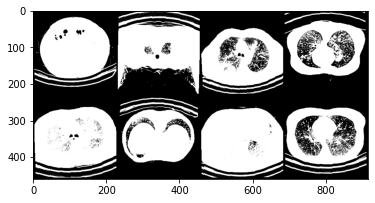

In [53]:
#testing above code
batch=next(iter(DataLoader(DataReader(train_df,aug), batch_size = 8, num_workers=1,shuffle=True)))
print(batch[0][0].shape)

from torch.utils.data.dataloader import DataLoader
import torchvision
import matplotlib.pyplot as plt
grid_img=torchvision.utils.make_grid(batch[0],4,4)
plt.imshow(grid_img.permute(1, 2, 0))

In [54]:
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as cp
from collections import OrderedDict
from torch import Tensor
from typing import Any, List, Tuple




class _DenseLayer(nn.Module):
    def __init__(
        self,
        num_input_features: int,
        growth_rate: int,
        bn_size: int,
        drop_rate: float,
        memory_efficient: bool = False
    ) -> None:
        super(_DenseLayer, self).__init__()
        self.norm1: nn.BatchNorm2d
        self.add_module('norm1', nn.BatchNorm2d(num_input_features))
        self.relu1: nn.ReLU
        self.add_module('relu1', nn.ReLU(inplace=True))
        self.conv1: nn.Conv2d
        self.add_module('conv1', nn.Conv2d(num_input_features, bn_size *
                                           growth_rate, kernel_size=1, stride=1,
                                           bias=False))
        self.norm2: nn.BatchNorm2d
        self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate))
        self.relu2: nn.ReLU
        self.add_module('relu2', nn.ReLU(inplace=True))
        self.conv2: nn.Conv2d
        self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate,
                                           kernel_size=3, stride=1, padding=1,
                                           bias=False))
        self.drop_rate = float(drop_rate)
        self.memory_efficient = memory_efficient

    def bn_function(self, inputs: List[Tensor]) -> Tensor:
        concated_features = torch.cat(inputs, 1)
        bottleneck_output = self.conv1(self.relu1(self.norm1(concated_features)))  # noqa: T484
        return bottleneck_output

    # todo: rewrite when torchscript supports any
    def any_requires_grad(self, input: List[Tensor]) -> bool:
        for tensor in input:
            if tensor.requires_grad:
                return True
        return False

    @torch.jit.unused  # noqa: T484
    def call_checkpoint_bottleneck(self, input: List[Tensor]) -> Tensor:
        def closure(*inputs):
            return self.bn_function(inputs)

        return cp.checkpoint(closure, *input)

    @torch.jit._overload_method  # noqa: F811
    def forward(self, input: List[Tensor]) -> Tensor:
        pass

    @torch.jit._overload_method  # noqa: F811
    def forward(self, input: Tensor) -> Tensor:
        pass

    # torchscript does not yet support *args, so we overload method
    # allowing it to take either a List[Tensor] or single Tensor
    def forward(self, input: Tensor) -> Tensor:  # noqa: F811
        if isinstance(input, Tensor):
            prev_features = [input]
        else:
            prev_features = input

        if self.memory_efficient and self.any_requires_grad(prev_features):
            if torch.jit.is_scripting():
                raise Exception("Memory Efficient not supported in JIT")

            bottleneck_output = self.call_checkpoint_bottleneck(prev_features)
        else:
            bottleneck_output = self.bn_function(prev_features)

        new_features = self.conv2(self.relu2(self.norm2(bottleneck_output)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate,
                                     training=self.training)
        return new_features


class _DenseBlock(nn.ModuleDict):
    _version = 2

    def __init__(
        self,
        num_layers: int,
        num_input_features: int,
        bn_size: int,
        growth_rate: int,
        drop_rate: float,
        memory_efficient: bool = False
    ) -> None:
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(
                num_input_features + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient,
            )
            self.add_module('denselayer%d' % (i + 1), layer)

    def forward(self, init_features: Tensor) -> Tensor:
        features = [init_features]
        for name, layer in self.items():
            new_features = layer(features)
            features.append(new_features)
        return torch.cat(features, 1)


class _Transition(nn.Sequential):
    def __init__(self, num_input_features: int, num_output_features: int) -> None:
        super(_Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(num_input_features, num_output_features,
                                          kernel_size=1, stride=1, bias=False))
        self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))


class DenseNet(nn.Module):
    r"""Densenet-BC model class, based on
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_.
    Args:
        growth_rate (int) - how many filters to add each layer (`k` in paper)
        block_config (list of 4 ints) - how many layers in each pooling block
        num_init_features (int) - the number of filters to learn in the first convolution layer
        bn_size (int) - multiplicative factor for number of bottle neck layers
          (i.e. bn_size * k features in the bottleneck layer)
        drop_rate (float) - dropout rate after each dense layer
        num_classes (int) - number of classification classes
        memory_efficient (bool) - If True, uses checkpointing. Much more memory efficient,
          but slower. Default: *False*. See `"paper" <https://arxiv.org/pdf/1707.06990.pdf>`_.
    """

    def __init__(
        self,
        growth_rate: int = 32,
        block_config: Tuple[int, int, int, int] = (6, 12, 24, 16),
        num_init_features: int = 64,
        bn_size: int = 4,
        drop_rate: float = 0,
        num_classes: int = 1000,
        memory_efficient: bool = False
    ) -> None:

        super(DenseNet, self).__init__()

        # First convolution
        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(1, num_init_features, kernel_size=7, stride=2,
                                padding=3, bias=False)),
            ('norm0', nn.BatchNorm2d(num_init_features)),
            ('relu0', nn.ReLU(inplace=True)),
            ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
        ]))

        # Each denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient
            )
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features,
                                    num_output_features=num_features // 2)
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))
##############################################################################################
        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)
        


        # Official init from torch repo.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x: Tensor) -> Tensor:
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        
        
        return out





def _densenet(
    arch: str,
    growth_rate: int,
    block_config: Tuple[int, int, int, int],
    num_init_features: int,
   
    **kwargs: Any
) -> DenseNet:
    model = DenseNet(growth_rate, block_config, num_init_features, **kwargs)
    return model


def densenet121( **kwargs: Any) -> DenseNet:
    r"""Densenet-121 model from
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
        memory_efficient (bool) - If True, uses checkpointing. Much more memory efficient,
          but slower. Default: *False*. See `"paper" <https://arxiv.org/pdf/1707.06990.pdf>`_.
    """
    return _densenet('densenet121', 32, (6, 12, 24, 16), 64,
                     **kwargs)

In [55]:
x=torch.randn(3,1,224,224)
model=densenet121()
model(x).shape

torch.Size([3, 1000])

In [57]:
class OurModel(LightningModule):
  def __init__(self):
    super(OurModel,self).__init__()
    #architecute
    self.model =densenet121()
    self.fc1= nn.Linear(1000,500)
    self.fc2= nn.Linear(500,3)
    self.relu = nn.ReLU()
    
  #parameters
    self.lr=0.001
    self.batch_size=128
    self.numworker=1
    self.train_acc = torchmetrics.Accuracy()
    self.val_acc = torchmetrics.Accuracy()
    self.test_acc = torchmetrics.Accuracy()
    self.class_weights =torch.tensor(class_weight.compute_class_weight('balanced',\
                  np.unique(train_df.label),train_df.label),dtype=torch.float32)
    
  def forward(self,x):
    x= self.model(x)
    x= self.fc1(x)
    x= self.relu(x)
    x= self.fc2(x) 
    return x

 

  def configure_optimizers(self):
    return torch.optim.Adam(params=self.parameters(),lr=self.lr )

  def train_dataloader(self):
    return DataLoader(DataReader(train_df,aug), batch_size = self.batch_size, num_workers=self.numworker,shuffle=True)

  def training_step(self,batch,batch_idx):
    image,label=batch
    out=self(image)
    loss=torch.nn.functional.cross_entropy(out,label,self.class_weights)
    pred=torch.max(out,dim=1)[1]
    train_acc=self.train_acc(pred,label)
    self.log('train/acc', train_acc, on_epoch=True,prog_bar=True)
    self.log('train/loss', loss, on_epoch=True,prog_bar=True)
    return loss

  def val_dataloader(self):
    return DataLoader(DataReader(val_df,aug), batch_size = self.batch_size,num_workers=self.numworker,  shuffle=False)
    
  def validation_step(self,batch,batch_idx):
    image,label=batch
    out=self(image)
    loss=torch.nn.functional.cross_entropy(out,label,self.class_weights)
    pred=torch.max(out,dim=1)[1]
    valid_acc=self.val_acc(pred,label)
    self.log('val/acc', valid_acc, on_epoch=True,prog_bar=True)
    self.log('val/loss', loss, on_epoch=True,prog_bar=True)
    return loss

  def test_dataloader(self):
    return DataLoader(DataReader(val_df,aug), batch_size = self.batch_size,num_workers=self.numworker,  shuffle=False)
    
  def test_step(self,batch,batch_idx):
    image,label=batch
    out=self(image)
    loss=torch.nn.functional.cross_entropy(out,label,self.class_weights)
    pred=torch.max(out,dim=1)[1]
    test_acc=self.test_acc(pred,label)
    self.log('test/acc', test_acc, on_epoch=True,prog_bar=True)
    self.log('test/loss', loss, on_epoch=True,prog_bar=True)
    return loss

In [60]:
train_df=train_df[0:100]
val_df=val_df[0:100]

In [ ]:
early_stop_callback = EarlyStopping(monitor='val/loss', min_delta=0.00, patience=2, verbose=True, mode='min')
checkpoint_callback = ModelCheckpoint(monitor='val/loss',dirpath='/content/drive/MyDrive/',
                                      filename='covidctmd' )
model = OurModel()
trainer = Trainer(max_epochs=1, auto_lr_find=False, auto_scale_batch_size=False,
                  tpu_cores=8,precision=16,
                  #gpus=-1,
                  progress_bar_refresh_rate=30, 
                  callbacks=[early_stop_callback]
                  )
trainer.tune(model)
trainer.fit(model)

GPU available: False, used: False
TPU available: True, using: 8 TPU cores

  | Name      | Type     | Params
---------------------------------------
0 | model     | DenseNet | 8.0 M 
1 | fc1       | Linear   | 500 K 
2 | fc2       | Linear   | 1.5 K 
3 | relu      | ReLU     | 0     
4 | train_acc | Accuracy | 0     
5 | val_acc   | Accuracy | 0     
6 | test_acc  | Accuracy | 0     
---------------------------------------
8.5 M     Trainable params
0         Non-trainable params
8.5 M     Total params
16.949    Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  /pytorch/aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:594

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  /pytorch/aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:594

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  /pytorch/aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:594

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/chest_covidctmd.pt')

In [ ]:
trainer.test(model)

In [ ]:
test_loader=DataLoader(DataReader(val_df,aug), batch_size = 64,num_workers=1,  shuffle=False)
model.eval()
with torch.no_grad():
  preds,labels=[],[]
  for img, lab in test_loader:
    pred=model(img)

    preds.append(pred.detach().numpy())
    labels.append(lab)

In [ ]:
preds=np.concatenate(preds)
labels=np.concatenate(labels)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(labels,pred))